In [ ]:
!pip install -U ray
!pip install tune-sklearn ray[tune]
!pip install shap
!pip install ipympl

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import spearmanr, ks_2samp, kstest
import numpy as np
import seaborn as sn
import mpl_toolkits
from matplotlib.colors import LogNorm, Normalize
from matplotlib import colors

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import silhouette_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel, VarianceThreshold,  SelectorMixin
from sklearn.utils import class_weight, check_array
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
import sklearn.metrics as metrics

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.classifier import ROCAUC

from ray.tune.sklearn import TuneSearchCV
from ray import tune
import shap
import joblib

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial data exploration

Quick general overview of our dataset, finding out about information that's important to all of our hyptoheses. 

Full dataset and descriptions of features can be found at:
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars


In [4]:
os.chdir('/content/drive/MyDrive/OZNAL/projekt')

In [5]:
df = pd.read_csv('data_only.csv')
df.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,disc_year,disc_refname,disc_pubdate,disc_locale,disc_facility,disc_telescope,disc_instrument,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbper_reflink,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmax_reflink,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_rade_reflink,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radj_reflink,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmasse_reflink,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassj_reflink,pl_bmassprov,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_dens_reflink,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccen_reflink,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_insol_reflink,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_eqt_reflink,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincl_reflink,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tranmid_systemref,pl_tranmid_reflink,ttv_flag,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_imppar_reflink,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandep_reflink,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_trandur_reflink,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratdor_reflink,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_ratror_reflink,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_occdep_reflink,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orbtper_systemref,pl_orbtper_reflink,pl_orblper,pl_orblpererr1,pl_orblpererr2,pl_orblperlim,pl_orblper_reflink,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_rvamp_reflink,pl_projobliq,pl_projobliqerr1,pl_projobliqerr2,pl_projobliqlim,pl_projobliq_reflink,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,pl_trueobliqlim,pl_trueobliq_reflink,...,st_masserr1,st_masserr2,st_masslim,st_mass_reflink,st_met,st_meterr1,st_meterr2,st_metlim,st_met_reflink,st_metratio,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_lum_reflink,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_logg_reflink,st_age,st_ageerr1,st_ageerr2,st_agelim,st_age_reflink,st_dens,st_denserr1,st_denserr2,st_denslim,st_dens_reflink,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,st_vsin_reflink,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,st_rotp_reflink,st_radv,st_radverr1,st_radverr2,st_radvlim,st_radv_reflink,rastr,ra,decstr,dec,glat,glon,elat,elon,ra_reflink,sy_pm,sy_pmerr1,sy_pmerr2,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_pm_reflink,sy_dist,sy_disterr1,sy_disterr2,sy_dist_reflink,sy_plx,sy_plxerr1,sy_plxerr2,sy_plx_reflink,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_bmag_reflink,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_vmag_reflink,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_jmag_reflink,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmag_reflink,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_kmag_reflink,sy_umag,sy_umagerr1,sy_umagerr2,sy_umag_reflink,sy_gmag,sy_gmagerr1,sy_gmagerr2,sy_gmag_reflink,sy_rmag,sy_rmagerr1,sy_rmagerr2,sy_rmag_reflink,sy_imag,sy_imagerr1,sy_imagerr2,sy_imag_reflink,sy_zmag,sy_zmagerr1,sy_zmagerr2,sy_zmag_reflink,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w1mag_reflink,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w2mag_reflink,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w3mag_reflink,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_w4mag_reflink,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_gaiamag_reflink,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_icmag_reflink,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_tmag_reflink,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,2,1,0,0,Radial Velocity,2007,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,2008-01,Ground,Xinglong Station,2.16 m Telescope,Coude Echelle Spectrograph,1,0,0,0,0,0,0,0,0,0,0,326.03000,0.32,

In [ ]:
# df[df['sy_dist'] < 10]

Dataset contains ints, floats and strings. The strings all appear to be URLs or IDs, which won't be useful for any of our hypotheses, which will simplify further data processing.

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Data columns (total 313 columns):
 #    Column                Dtype  
---   ------                -----  
 0    rowid                 int64  
 1    pl_name               object 
 2    hostname              object 
 3    pl_letter             object 
 4    hd_name               object 
 5    hip_name              object 
 6    tic_id                object 
 7    gaia_id               object 
 8    sy_snum               int64  
 9    sy_pnum               int64  
 10   sy_mnum               int64  
 11   cb_flag               int64  
 12   discoverymethod       object 
 13   disc_year             int64  
 14   disc_refname          object 
 15   disc_pubdate          object 
 16   disc_locale           object 
 17   disc_facility         object 
 18   disc_telescope        object 
 19   disc_instrument       object 
 20   rv_flag               int64  
 21   pul_flag              int64  
 22   ptv_flag              

In [6]:
df = df[[col for col in df.columns if 'ref' not in col and 'link' not in col]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Columns: 253 entries, rowid to pl_ntranspec
dtypes: float64(212), int64(23), object(18)
memory usage: 9.5+ MB


Our data also contains a lot of missing values that we'll have to deal with. More than 30% of features contains at least 20% missing values.

In [ ]:
df.isna().sum()[df.isna().sum() > 0]

hd_name             4126
hip_name            4044
tic_id               137
gaia_id              180
pl_orbper            163
pl_orbpererr1        649
pl_orbpererr2        649
pl_orbperlim         163
pl_orbsmax           200
pl_orbsmaxerr1      2761
pl_orbsmaxerr2      2762
pl_orbsmaxlim        199
pl_rade               14
pl_radeerr1         1477
pl_radeerr2         1477
pl_radelim            14
pl_radj               16
pl_radjerr1         1479
pl_radjerr2         1479
pl_radjlim            16
pl_bmasse             22
pl_bmasseerr1       2928
pl_bmasseerr2       2928
pl_bmasselim          22
pl_bmassj             22
pl_bmassjerr1       2928
pl_bmassjerr2       2928
pl_bmassjlim          22
pl_dens              106
pl_denserr1         4118
pl_denserr2         4118
pl_denslim           106
pl_orbeccen          576
pl_orbeccenerr1     3613
pl_orbeccenerr2     3613
pl_orbeccenlim       576
pl_insol            1738
pl_insolerr1        1849
pl_insolerr2        1849
pl_insollim         1830


In [ ]:
len(df.columns[df.isna().sum() > 4933/5])

135

# Hypothesis 1 - Location clustering analysis

Our first hypothesis is focused on analysing the distribution of known planets in the universe. We'll only need planetary coordinates for this task, which makes our task significantly easier.

In [6]:
# Copying planet coordinates
location_df = df[['rowid', 'ra', 'dec', 'sy_dist']].copy()

In [7]:
location_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rowid    4933 non-null   int64  
 1   ra       4933 non-null   float64
 2   dec      4933 non-null   float64
 3   sy_dist  4918 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 154.3 KB


In [8]:
df[df['sy_dist'].isna()].head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,disc_year,disc_refname,disc_pubdate,disc_locale,disc_facility,disc_telescope,disc_instrument,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbper_reflink,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmax_reflink,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_rade_reflink,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radj_reflink,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmasse_reflink,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassj_reflink,pl_bmassprov,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_dens_reflink,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccen_reflink,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_insol_reflink,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_eqt_reflink,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincl_reflink,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tranmid_systemref,pl_tranmid_reflink,ttv_flag,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_imppar_reflink,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandep_reflink,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_trandur_reflink,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratdor_reflink,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_ratror_reflink,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_occdep_reflink,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orbtper_systemref,pl_orbtper_reflink,pl_orblper,pl_orblpererr1,pl_orblpererr2,pl_orblperlim,pl_orblper_reflink,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_rvamp_reflink,pl_projobliq,pl_projobliqerr1,pl_projobliqerr2,pl_projobliqlim,pl_projobliq_reflink,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,pl_trueobliqlim,pl_trueobliq_reflink,...,st_masserr1,st_masserr2,st_masslim,st_mass_reflink,st_met,st_meterr1,st_meterr2,st_metlim,st_met_reflink,st_metratio,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_lum_reflink,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_logg_reflink,st_age,st_ageerr1,st_ageerr2,st_agelim,st_age_reflink,st_dens,st_denserr1,st_denserr2,st_denslim,st_dens_reflink,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,st_vsin_reflink,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,st_rotp_reflink,st_radv,st_radverr1,st_radverr2,st_radvlim,st_radv_reflink,rastr,ra,decstr,dec,glat,glon,elat,elon,ra_reflink,sy_pm,sy_pmerr1,sy_pmerr2,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_pm_reflink,sy_dist,sy_disterr1,sy_disterr2,sy_dist_reflink,sy_plx,sy_plxerr1,sy_plxerr2,sy_plx_reflink,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_bmag_reflink,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_vmag_reflink,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_jmag_reflink,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmag_reflink,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_kmag_reflink,sy_umag,sy_umagerr1,sy_umagerr2,sy_umag_reflink,sy_gmag,sy_gmagerr1,sy_gmagerr2,sy_gmag_reflink,sy_rmag,sy_rmagerr1,sy_rmagerr2,sy_rmag_reflink,sy_imag,sy_imagerr1,sy_imagerr2,sy_imag_reflink,sy_zmag,sy_zmagerr1,sy_zmagerr2,sy_zmag_reflink,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w1mag_reflink,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w2mag_reflink,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w3mag_reflink,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_w4mag_reflink,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_gaiamag_reflink,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_icmag_reflink,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_tmag_reflink,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
74,75,CFHTWIR-Oph 98 b,CFHTWIR-Oph 98 A,b,NaN,NaN,TIC 175744063,NaN,1,1,0,0,Imaging,2021,<a refstr=FONTANIVE_ET_AL__2020 href=https://u...,2020-12,Space,Hubble Space Telescope,2.4 m Hubble Space Telescope,WFC3 Camera,0,0,0,0,0,0,0,0,1,0,0,8.040000e+06,470000.0,-470000.0,0.0,<

Nothing seems to be linking all of these planets together - not the other coordinates, not stars, not sources of discovery, etc. so we just drop them as theres only 15 of them anyway.

In [9]:
location_df = location_df.dropna()
location_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4918 entries, 0 to 4932
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rowid    4918 non-null   int64  
 1   ra       4918 non-null   float64
 2   dec      4918 non-null   float64
 3   sy_dist  4918 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 192.1 KB


In [10]:
# Custom K-Means wrapper for easy experiments
def compute_clusters(df, min_req_clusters=2, num_clusters=3, retry=5, k_retry_step=10):
    df = df.copy()
    
    normalizer = StandardScaler()
    df['ra'] = normalizer.fit_transform(df['ra'].values.reshape(-1, 1))
    df['dec'] = normalizer.fit_transform(df['dec'].values.reshape(-1, 1))
    df['sy_dist'] = normalizer.fit_transform(df['sy_dist'].values.reshape(-1, 1))
    
    kmeans = KMeans(n_clusters=(num_clusters), random_state=1)

    transformed = kmeans.fit_predict(df[['ra', 'dec', 'sy_dist']])
    no_clusters = max(transformed)
    print
        
    return transformed
    

In [11]:
location_df['cluster'] = compute_clusters(location_df)
location_df['cluster'].value_counts()

1    3263
0    1551
2     104
Name: cluster, dtype: int64

Initial clustering attempts seem to show that there isn't a clear separation between individual clusters and we will need to perform a degree of visual inspection to identify possible problems.

In [12]:
silhouette_score(location_df, location_df['cluster'])    # Coefficient for analysing clusters. 1 - clusters are clearly distinguished and far apart; 0 - clusters overlap

0.26457251066521803

In [13]:
from google.colab import output
output.enable_custom_widget_manager()

When visualized, there are two noticable groups of outliers, which are significantly affecting our results.

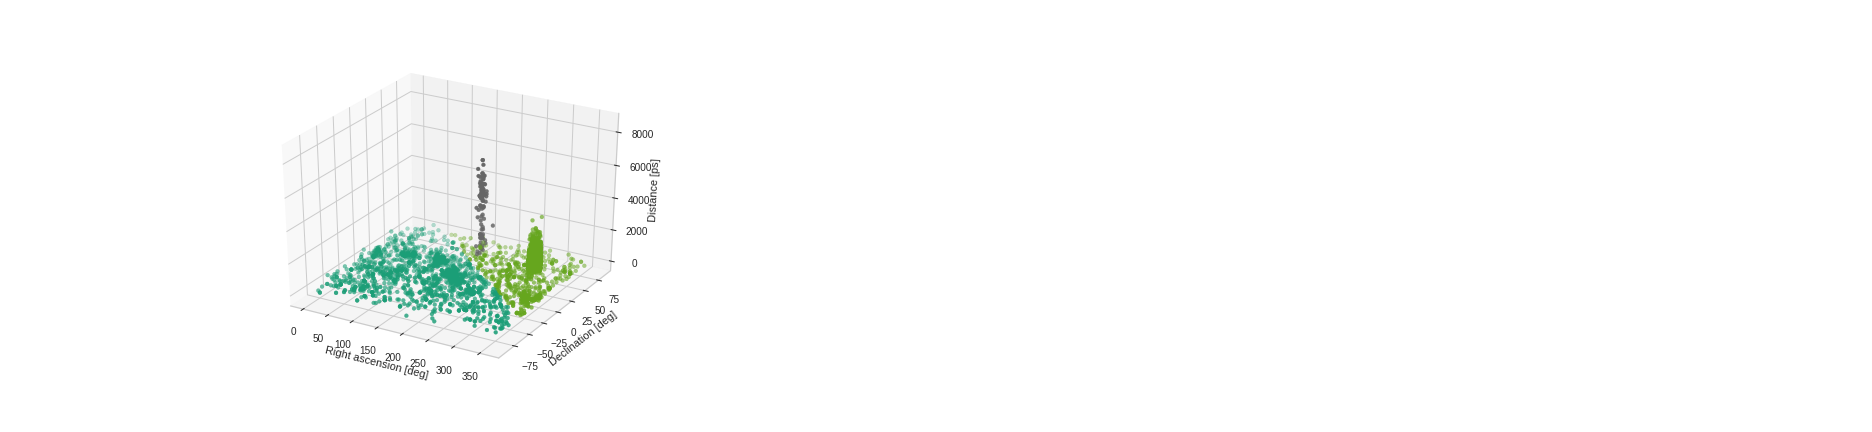

In [14]:
%matplotlib widget
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(location_df['ra'], location_df['dec'], location_df['sy_dist'], 
           c=location_df['cluster'], cmap='Dark2', s=15)

ax.set_xlabel('Right ascension [deg]')
ax.set_ylabel('Declination [deg]')
ax.set_zlabel('Distance [ps]')
plt.show()

In [ ]:
silhouette_score(location_df[location_df['sy_dist'] < 2000], location_df[location_df['sy_dist'] < 2000]['cluster'])

0.2611677700485603

Boolean Series key will be reindexed to match DataFrame index.


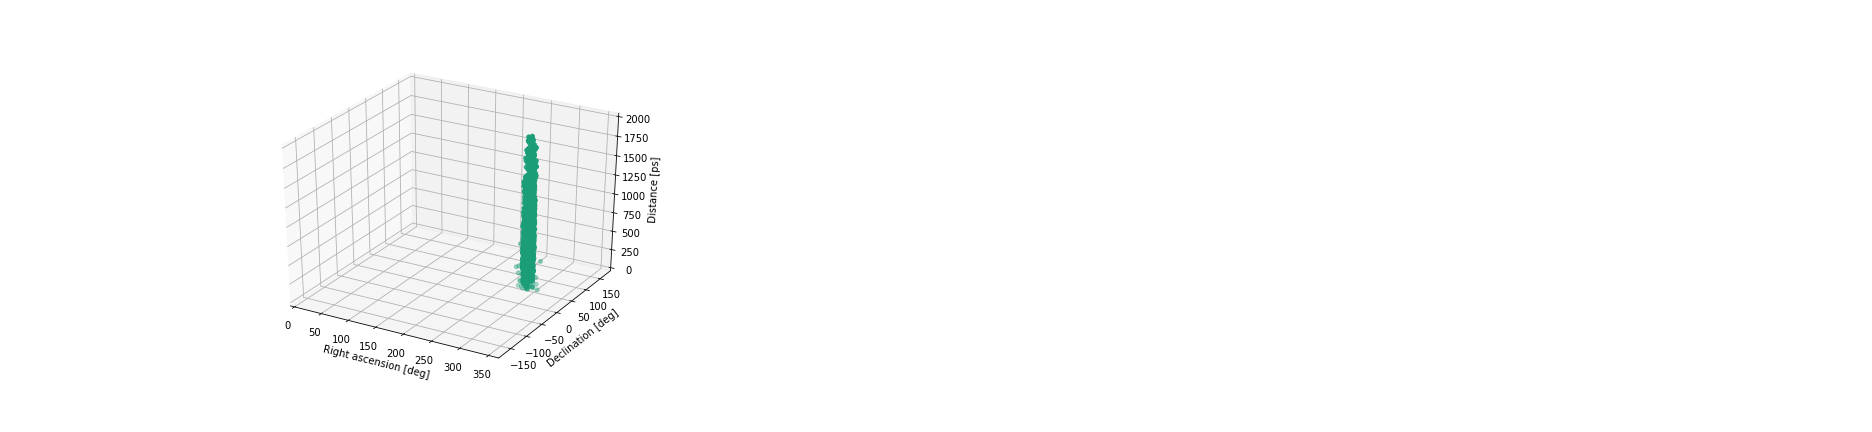

In [ ]:
%matplotlib widget

without_distant_df = location_df[location_df['sy_dist'] < 2000][location_df['dec'] > 30][location_df['dec'] < 60][location_df['ra'] > 270][location_df['ra'] < 310]

fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(without_distant_df['ra'], without_distant_df['dec'], without_distant_df['sy_dist'], 
           c=without_distant_df['cluster'], cmap='Dark2', s=15)

ax.set_xlim(0, 360)
ax.set_ylim(-180, 180)
ax.set_zlim(0, 2000)
ax.set_xlabel('Right ascension [deg]')
ax.set_ylabel('Declination [deg]')
ax.set_zlabel('Distance [ps]')
plt.show()

In [ ]:
df[df['disc_facility'] != 'Kepler']

We identified the outlying groups to belong to the Kepler and OGLE experiments. We removed both of these sources before proceeding with further analysis.

Boolean Series key will be reindexed to match DataFrame index.


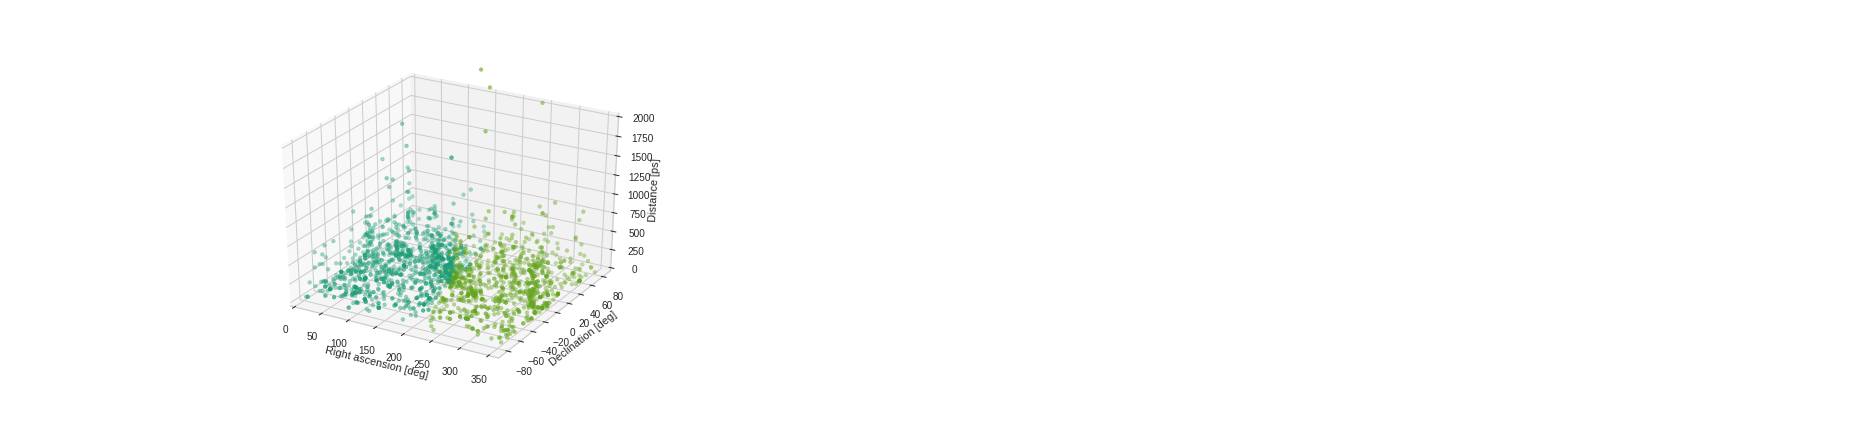

In [15]:
%matplotlib widget

location_df = df[df['disc_facility'] != 'Kepler'][df['disc_facility'] != 'OGLE'][['rowid', 'ra', 'dec', 'sy_dist']].copy()
location_df = location_df.dropna()
location_df['cluster'] = compute_clusters(location_df)

fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(location_df['ra'], location_df['dec'], location_df['sy_dist'], 
           c=location_df['cluster'], cmap='Dark2', s=15)

ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_zlim(0, 2000)
ax.set_xlabel('Right ascension [deg]')
ax.set_ylabel('Declination [deg]')
ax.set_zlabel('Distance [ps]')
plt.show()

Using KElbow to identify the opitmal number of clusters in our dataset. Setting a minimum of 10, as we judge it unlikely for such a clear distribution bias to occur in our universe that we would need fewer, and a maximum of 100 as with a higher number of clusters we risk detecting individual solar systems.

Boolean Series key will be reindexed to match DataFrame index.


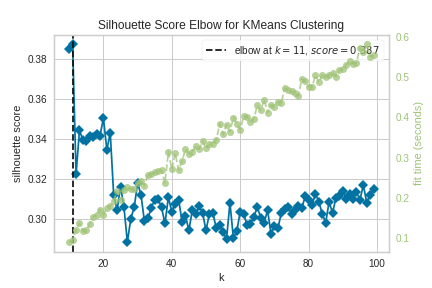

In [16]:
%matplotlib widget
cluster_df = df[df['disc_facility'] != 'Kepler'][df['disc_facility'] != 'OGLE'][['rowid', 'ra', 'dec', 'sy_dist']].copy()
cluster_df = cluster_df.dropna()

model = KMeans()

visualizer = KElbowVisualizer(model, k=(10,100),metric='silhouette', timings= True)
visualizer.fit(cluster_df[['ra', 'dec', 'sy_dist']])        
visualizer.show()

In [20]:
model = KMeans(n_clusters=11)
cluster_df['cluster'] = model.fit_predict(cluster_df[['ra', 'dec', 'sy_dist']])
silhouette_score(cluster_df[['ra', 'dec', 'sy_dist']], cluster_df['cluster']) 

0.38653165828095953

From both the increased Silhouette score and the visualization we can see that the separation between clusters increased. However it seems to still be mostly based on artifical layering of planets by their distance from Earth.

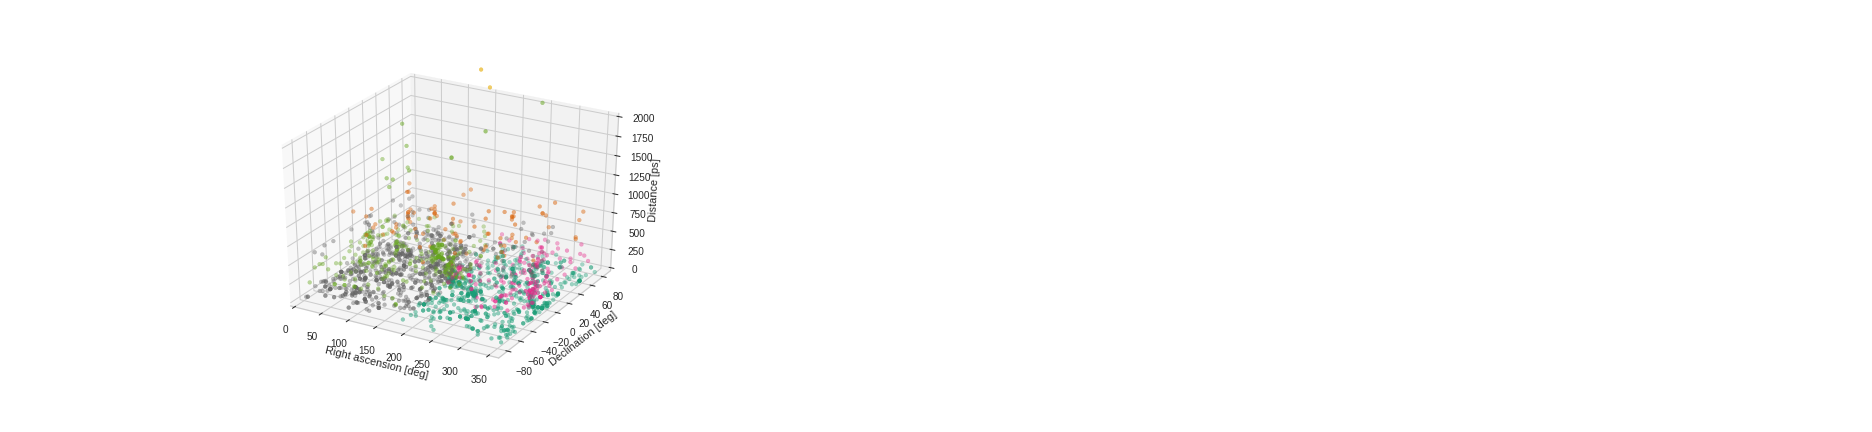

In [21]:
%matplotlib widget

fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(cluster_df['ra'], cluster_df['dec'], cluster_df['sy_dist'], 
           c=cluster_df['cluster'], cmap='Dark2', s=15)

ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_zlim(0, 2000)
ax.set_xlabel('Right ascension [deg]')
ax.set_ylabel('Declination [deg]')
ax.set_zlabel('Distance [ps]')
plt.show()

As the next step we analyse the data in 2D to see if we can pick up on patterns more easily this way.

Boolean Series key will be reindexed to match DataFrame index.


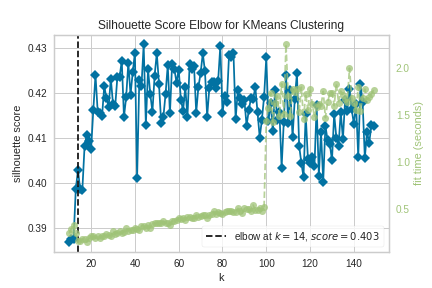

In [23]:
%matplotlib widget

cluster_df = df[df['disc_facility'] != 'Kepler'][df['disc_facility'] != 'OGLE'][['rowid', 'ra', 'dec', 'sy_dist']].copy()
cluster_df = cluster_df.dropna()

model = KMeans()

visualizer = KElbowVisualizer(model, k=(10,150),metric='silhouette', timings= True)
visualizer.fit(cluster_df[['ra', 'dec']])        
visualizer.show()

In [24]:
model = KMeans(n_clusters=10)
cluster_df['cluster'] = model.fit_predict(cluster_df[['ra', 'dec']])
silhouette_score(cluster_df[['ra', 'dec']], cluster_df['cluster']) 

0.40287293203603736

Again, both Silhouette score and the visualization indicate that we made the right move. Now there appear to be clearly visible clusters oscilating around the declination of 0 degrees (the Equator). As it happend, most of the observatories on Earth are located as close to the equator as possible, as it allows them to cover most of the sky.

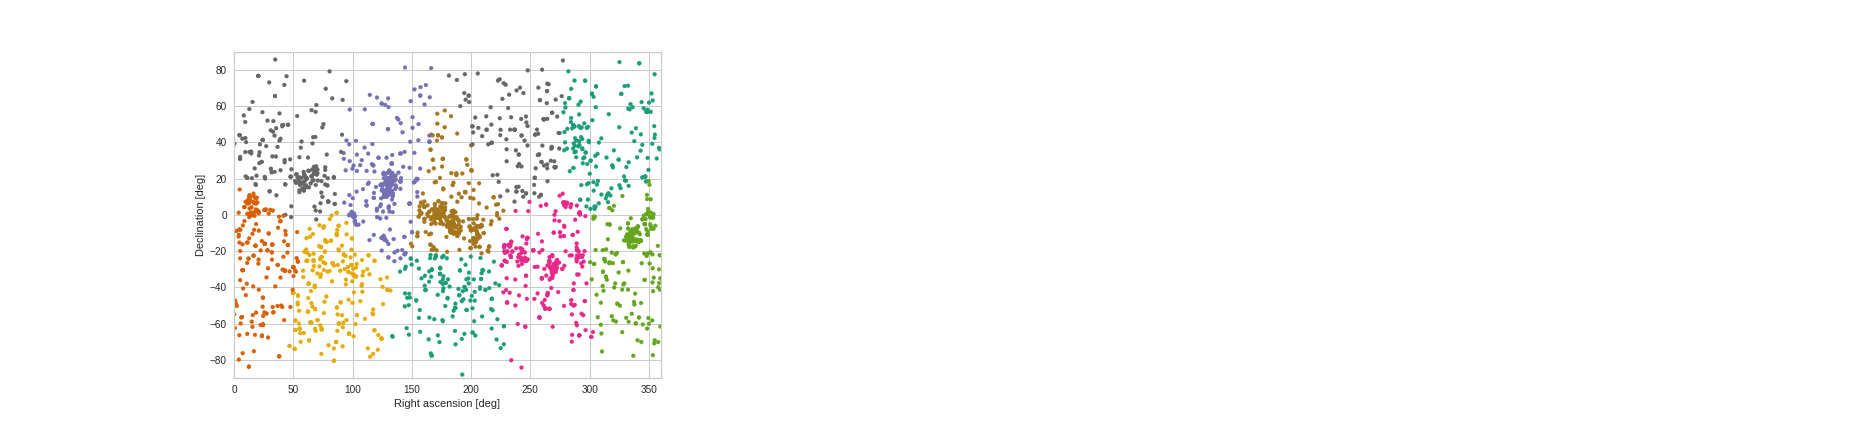

In [25]:
%matplotlib widget

fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131)
ax.scatter(cluster_df['ra'], cluster_df['dec'], c=cluster_df['cluster'], cmap='Dark2', s=15)

ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel('Right ascension [deg]')
ax.set_ylabel('Declination [deg]')
plt.show()

In [26]:
count_df = df[df['disc_facility'] != 'Kepler'][df['disc_facility'] != 'OGLE'][['rowid', 'ra', 'dec', 'sy_dist']].copy()
count_df['square'] = ''
planet_counts = []
count = 0 
for i in range(0, 360, 36):
  for j in range(-90, 90, 18):
    count_df[count_df['ra'] >= i ][count_df['ra'] < i + 36][count_df['dec'] >= j][count_df['dec'] < j+18]['square'] = count
    planet_counts.append(len(count_df[count_df['ra'] >= i ][count_df['ra'] < i + 36][count_df['dec'] >= j][count_df['dec'] < j+18]))
    count += 1


Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [28]:
count_df[count_df['ra'] >= i ][count_df['ra'] < i + 36][count_df['dec'] >= j][count_df['dec'] < j+18]['square']

Boolean Series key will be reindexed to match DataFrame index.


744     
776     
777     
4905    
Name: square, dtype: object

From the distribution graph of exoplanets in a 2D view it's clear that there's absolutely no uniformity and it's pointless to perform further statistical analysis.

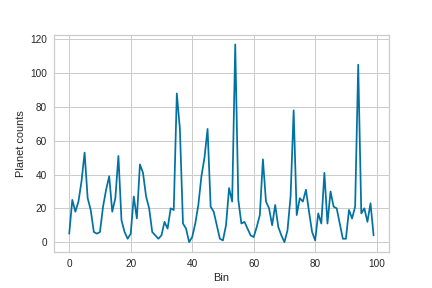

In [29]:
%matplotlib widget
plt.plot(planet_counts)
plt.ylabel('Planet counts')
plt.xlabel('Bin')
plt.show()

In [ ]:
# kstest(location_df['square'], stats.uniform(loc=0.0, scale=100.0).cdf)

In [ ]:
# distant_df['discoverymethod'].value_counts()

In [ ]:
# distant_df['disc_facility'].value_counts()

In [ ]:
# df['disc_facility'].value_counts()

# Hypothesis 2 - Discovery methods classification
The location of observatories is not
the only possible source of bias in our dataset
of exoplanets. The next source we investigate
are the methods used for detecting the planets
in our dataset.

## Initial classification specific data exploration

In [6]:
df[df.columns[df.isna().sum().values == 0]].columns       # Can't really base our predictions on non null columns as there's not a lot of them and half of them are just flags

Index(['rowid', 'pl_name', 'hostname', 'pl_letter', 'sy_snum', 'sy_pnum',
       'sy_mnum', 'cb_flag', 'discoverymethod', 'disc_year', 'disc_refname',
       'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope',
       'disc_instrument', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag',
       'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag',
       'dkin_flag', 'pl_controv_flag', 'pl_bmassprov', 'ttv_flag', 'rastr',
       'ra', 'decstr', 'dec', 'glat', 'glon', 'elat', 'elon', 'ra_reflink',
       'sy_pm_reflink', 'sy_dist_reflink', 'sy_plx_reflink', 'sy_bmag_reflink',
       'sy_vmag_reflink', 'sy_jmag_reflink', 'sy_hmag_reflink',
       'sy_kmag_reflink', 'sy_umag_reflink', 'sy_gmag_reflink',
       'sy_rmag_reflink', 'sy_imag_reflink', 'sy_zmag_reflink',
       'sy_w1mag_reflink', 'sy_w2mag_reflink', 'sy_w3mag_reflink',
       'sy_w4mag_reflink', 'sy_gaiamag_reflink', 'sy_icmag_reflink',
       'sy_tmag_reflink', 'sy_kepmag_reflink', 'st_nphot', 'st_nrvc',
   

In [7]:
df.select_dtypes(include='object').head()          # Object variables seem to be pretty useless - just units, ids, str encoding of coordinates, ...

,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,discoverymethod,disc_refname,disc_pubdate,disc_locale,disc_facility,disc_telescope,disc_instrument,pl_orbper_reflink,pl_orbsmax_reflink,pl_rade_reflink,pl_radj_reflink,pl_bmasse_reflink,pl_bmassj_reflink,pl_bmassprov,pl_dens_reflink,pl_orbeccen_reflink,pl_insol_reflink,pl_eqt_reflink,pl_orbincl_reflink,pl_tranmid_systemref,pl_tranmid_reflink,pl_imppar_reflink,pl_trandep_reflink,pl_trandur_reflink,pl_ratdor_reflink,pl_ratror_reflink,pl_occdep_reflink,pl_orbtper_systemref,pl_orbtper_reflink,pl_orblper_reflink,pl_rvamp_reflink,pl_projobliq_reflink,pl_trueobliq_reflink,st_spectype,st_spectype_reflink,st_teff_reflink,st_rad_reflink,st_mass_reflink,st_met_reflink,st_metratio,st_lum_reflink,st_logg_reflink,st_age_reflink,st_dens_reflink,st_vsin_reflink,st_rotp_reflink,st_radv_reflink,rastr,decstr,ra_reflink,sy_pm_reflink,sy_dist_reflink,sy_plx_reflink,sy_bmag_reflink,sy_vmag_reflink,sy_jmag_reflink,sy_hmag_reflink,sy_kmag_reflink,sy_umag_reflink,sy_gmag_reflink,sy_rmag_reflink,sy_imag_reflink,sy_zmag_reflink,sy_w1mag_reflink,sy_w2mag_reflink,sy_w3mag_reflink,sy_w4mag_reflink,sy_gaiamag_reflink,sy_icmag_reflink,sy_tmag_reflink,sy_kepmag_reflink
0,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Radial Velocity,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,2008-01,Ground,Xinglong Station,2.16 m Telescope,Coude Echelle Spectrograph,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=CALCULATED_VALUE href=/docs/composit...,<a refstr=CALCULATED_VALUE href=/docs/composit...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,Msini,<a refstr=CALCULATED_VALUE href=/docs/composit...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,NaN,NaN,G8 III,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,[Fe/H],<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,NaN,NaN,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,NaN,<a refstr=GAIA_COLLABORATION_ET_AL__2018 href=...,12h20m42.91s,+17d47m35.71s,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....
1,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Radial Velocity,<a refstr=DOLLINGER_ET_AL__2009 href=https://u...,2009-10,Ground,Thueringer Landessternwarte Tautenburg,2.0 m Alfred Jensch Telescope,Coude Echelle Spectrograph,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,<a refstr=STASSUN_ET_AL__2017 href=h

In [8]:
classification_df = df.select_dtypes(exclude='object').copy()
classification_target_df = df['discoverymethod'].copy()
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Columns: 235 entries, rowid to pl_ntranspec
dtypes: float64(212), int64(23)
memory usage: 8.8 MB


In [9]:
classification_df.head()

,rowid,sy_snum,sy_pnum,sy_mnum,cb_flag,disc_year,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,ttv_flag,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orblper,pl_orblpererr1,pl_orblpererr2,pl_orblperlim,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_projobliq,pl_projobliqerr1,pl_projobliqerr2,pl_projobliqlim,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,pl_trueobliqlim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_rad,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_met,st_meterr1,st_meterr2,st_metlim,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_age,st_ageerr1,st_ageerr2,st_agelim,st_dens,st_denserr1,st_denserr2,st_denslim,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,st_radv,st_radverr1,st_radverr2,st_radvlim,ra,dec,glat,glon,elat,elon,sy_pm,sy_pmerr1,sy_pmerr2,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_dist,sy_disterr1,sy_disterr2,sy_plx,sy_plxerr1,sy_plxerr2,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_umag,sy_umagerr1,sy_umagerr2,sy_gmag,sy_gmagerr1,sy_gmagerr2,sy_rmag,sy_rmagerr1,sy_rmagerr2,sy_imag,sy_imagerr1,sy_imagerr2,sy_zmag,sy_zmagerr1,sy_zmagerr2,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,2,1,0,0,2007,1,0,0,0,0,0,0,0,0,0,0,326.03000,0.32,-0.32,0.0,1.29,0.05,-0.05,0.0,12.1,NaN,NaN,0.0,1.08,NaN,NaN,0.0,6165.6000,476.7000,-476.7000,0.0,19.40,1.50,-1.50,0.0,19.10,NaN,NaN,0.0,0.231,0.005,-0.005,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2452899.60,1.60,-1.60,0.0,94.80,1.50,-1.50,0.0,302.8,2.6,-2.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4742.0,100.0,-100.0,0.0,19.00,2.00,-2.00,0.0,2.70,0.30,-0.30,0.0,-0.35,0.09,-0.09,0.0,2.243,0.071,-0.085,0.0,2.31,0.10,-0.10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,1.0,-1.0,0.0,NaN,NaN,NaN,NaN,43.37,0.21,-0.21,0.0,185.178779,17.793252,78.28058,264.13775,18.33392,177.42177,140.383627,0.301395,-0.301395,-109.24100,0.316107,-0.316107,88.1701,0.277297,-0.277297,93.1846,1.9238,-1.9238,10.71040,0.219739,-0.219739,5.726,0.017000,-0.017000,4.72307,0.023,-0.023,2.943,0.334,-0.334,2.484,0.268,-0.268,2.282,0.346,-0.346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639,NaN,NaN,0.732,NaN,NaN,2.358,0.010,-0.010,2.270,0.018,-0.018,4.44038,0.003848,-0.003848,NaN,NaN,NaN,3.83790,0.0071,-0.0071,NaN,NaN,NaN,2.0,1,2,0,0,0
1,2,1,1,0,0,2009,1,0,0,0,0,0,0,0,0,0,0,516.21997,3.20,-3.20,0.0,1.53,0.07,-0.07,0.0,12.3,NaN,NaN,0.0,1.09,NaN,NaN,0.0,4684.8142,794.5750,-7

In [10]:
classification_df = classification_df[[col for col in classification_df.columns if 'flag' not in col]]      # Dropping flags - they are basically just target encodings
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Columns: 222 entries, rowid to pl_ntranspec
dtypes: float64(212), int64(10)
memory usage: 8.4 MB


In [11]:
classification_df.select_dtypes(include=np.int64)

,rowid,sy_snum,sy_pnum,sy_mnum,disc_year,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,2,1,0,2007,1,2,0,0,0
1,2,1,1,0,2009,1,1,0,0,0
2,3,1,1,0,2008,1,1,0,0,0
3,4,1,2,0,2002,1,4,1,0,0
4,5,3,1,0,1996,1,4,3,0,0
...,...,...,...,...,...,...,...,...,...,...
4928,4929,2,3,0,1996,1,10,1,0,0
4929,4930,2,3,0,1999,1,10,1,0,0
4930,4931,2,3,0,1999,1,10,1,0,0
4931,4932,1,1,0,2021,0,0,0,0,0


Flags + year = categorical, rest ordinal

In [12]:
len(classification_df.select_dtypes(include=np.float64).columns)

212

In [13]:
len(classification_df.columns[(classification_df.isna().sum() < 500).values])

95

More than 50% of float features have more than 25% missing values

## Data cleaning

In [14]:
feature_df = classification_df.drop(columns=classification_df.columns[(classification_df.isna().sum() > 500).values])
target_df = classification_target_df
feature_df.shape

(4933, 95)

In [15]:
imputer = SimpleImputer(strategy='median')
feature_df = imputer.fit_transform(feature_df)

In [16]:
target_df.isna().sum()

0

In [17]:
feature_df = pd.DataFrame(feature_df, columns=classification_df.columns[(classification_df.isna().sum() <= 500).values])

In [18]:
feature_df.shape

(4933, 95)

### Variance Filter

In [19]:
var_thresh = VarianceThreshold(0.1)
var_thresh.fit_transform(feature_df)

feature_df = feature_df[var_thresh.get_feature_names_out()]
feature_df.shape

(4933, 59)

### Correlation filter

In [20]:
class CorrelationThreshold(BaseEstimator, SelectorMixin):
    def __init__(self, threshold=0.9, kind='pearson'):
        self.threshold = threshold
        self.kind = kind

    def fit(self, X, y=None):
      
        if not (0.0 <= self.threshold <= 1.0):
            raise ValueError("threshold must be in [0.0, 1.0], got {}".format(
                             self.threshold))
        if self.kind not in ('pearson', 'spearmanr'):
            raise ValueError("kind must be 'pearson' or 'spearmanr'")

        X = check_array(X, accept_sparse=['csc', 'csr'], dtype=[np.float64,
                                                                np.float32])

        n_features = X.shape[1]
        if self.threshold == 1.0 or (1 in X.shape):
            self.support_mask_ = np.ones(n_features, dtype=np.bool)
            return self

        # get constant features
        
        peak_to_peaks = np.ptp(X, axis=0)
        constant_mask = np.isclose(peak_to_peaks, 0.0)

        if self.kind == 'pearson':
            X_corr = np.corrcoef(X, rowvar=False)
        else:  # spearmanr
            X_corr, _ = spearmanr(X)
            # spearmanr returns scaler when comparing two columns
            if isinstance(X_corr, float):
                X_corr = np.array([[1, X_corr], [X_corr, 1]])

        np.fabs(X_corr, out=X_corr)

        # Removes constant features from support_mask
        support_mask = np.ones(n_features, dtype=np.bool)
        upper_idx = np.triu_indices(n_features, 1)

        non_constant_features = n_features
        for i in np.flatnonzero(constant_mask):
            feat_remove_mask = np.logical_and(upper_idx[0] != i,
                                              upper_idx[1] != i)
            upper_idx = (upper_idx[0][feat_remove_mask],
                         upper_idx[1][feat_remove_mask])
            support_mask[i] = False
            non_constant_features -= 1

        for _ in range(non_constant_features - 1):
            max_idx = np.argmax(X_corr[upper_idx])
            feat1, feat2 = upper_idx[0][max_idx], upper_idx[1][max_idx]
            cur_corr = X_corr[feat1, feat2]

            # max correlation is lower than threshold
            if cur_corr < self.threshold:
                break

            # Temporary remove both features to calculate the mean with other
            # features. One of the features will be selected.
            support_mask[[feat1, feat2]] = False

            # if there are no other features to compare, keep the feature with
            # the most variance
            if np.all(~support_mask):
                
                var = np.var(X[:, [feat1, feat2]], axis=0)

                print(feat1, feat2)
                if var[0] < var[1]:
                    support_mask[feat2] = True
                else:
                    support_mask[feat1] = True
                break

            # means with other features
            feat1_mean = np.mean(X_corr[feat1, support_mask])
            feat2_mean = np.mean(X_corr[feat2, support_mask])

            # feature with lower mean is kept
            if feat1_mean < feat2_mean:
                support_mask[feat1] = True
                feat_to_remove = feat2
            else:
                support_mask[feat2] = True
                feat_to_remove = feat1

            # Removes the removed feature from consideration
            upper_idx_to_keep = np.logical_and(upper_idx[0] != feat_to_remove,
                                               upper_idx[1] != feat_to_remove)
            upper_idx = (upper_idx[0][upper_idx_to_keep],
                         upper_idx[1][upper_idx_to_keep])

        self.support_mask_ = support_mask
        return self

    def _get_support_mask(self):
        check_is_fitted(self)
        return self.support_mask_


In [28]:
corr_thresh = CorrelationThreshold()
corr_thresh = corr_thresh.fit(feature_df)

feature_df = feature_df[feature_df.columns[corr_thresh.support_mask_]]
feature_df = feature_df.loc[:, feature_df.columns!='disc_year']
feature_df.shape

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(4933, 38)

### Target preparation

In [21]:
other_list = ['Pulsation Timing Variations', 'Astrometry', 'Disk Kinematics'] # ['Imaging', 'Transit Timing Variations', 'Eclipse Timing Variations', 'Orbital Brightness Modulation', 'Pulsar Timing', 'Pulsation Timing Variations', 'Astrometry', 'Disk Kinematics']
target_df = target_df.replace(to_replace=other_list, value='Other')
target_df.value_counts()

Transit                          3778
Radial Velocity                   915
Microlensing                      124
Imaging                            58
Transit Timing Variations          22
Eclipse Timing Variations          16
Orbital Brightness Modulation       9
Pulsar Timing                       7
Other                               4
Name: discoverymethod, dtype: int64

In [22]:
labels = ['Eclipse Timing Variations', 'Imaging', 'Microlensing', 'Orbital Brightness Modulation', 'Other', 'Pulsar Timing', 'Radial Velocity', 'Transit', 'Transit Timing Variations']
labels

['Eclipse Timing Variations',
 'Imaging',
 'Microlensing',
 'Orbital Brightness Modulation',
 'Other',
 'Pulsar Timing',
 'Radial Velocity',
 'Transit',
 'Transit Timing Variations']

## Training preparations

In [23]:
target_encoder = OrdinalEncoder()
target_df = target_encoder.fit_transform(target_df.values.reshape(-1, 1))
np.unique(target_df, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([  16,   58,  124,    9,    4,    7,  915, 3778,   22]))

In [24]:
weight = compute_class_weight(class_weight='balanced', 
                              classes=np.unique(target_df.T[0]), 
                              y=target_df.T[0])
weight

array([ 34.25694444,   9.45019157,   4.4202509 ,  60.90123457,
       137.02777778,  78.3015873 ,   0.59902854,   0.1450797 ,
        24.91414141])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.loc[:, feature_df.columns!='rowid'], target_df, test_size=0.2, random_state=1, stratify=target_df)

In [84]:
def measure_similarity(X_train, X_test):
  cmp_arr = np.array([])
  for col in X_train.columns:
    cache = np.array([])
    for func in [np.mean, np.median, np.std]:
      train_data = X_train[col].values
      test_data = X_test[col].values

      train_func = func(train_data)
      test_func = func(test_data)
      pct_diff = np.abs(1 - test_func/train_func)

      cache = np.append(cache, [train_func, test_func, pct_diff], axis=0)
    
    if len(cmp_arr) == 0:
      cmp_arr = np.append(cmp_arr, cache, axis=0)
    else:
      cmp_arr = np.vstack([cmp_arr, cache])
  
  return pd.DataFrame(cmp_arr, index=X_train.columns, columns = ['Train mean', 'Test mean', 'Mean pct difference',
                                                                 'Train median', 'Test median', 'Median pct difference',
                                                                 'Train std', 'Test std', 'Std pct difference'])

In [85]:
similarity_df = measure_similarity(X_train.loc[:, X_train.columns!='rowid'], X_test.loc[:, X_test.columns!='rowid'])
similarity_df

invalid value encountered in double_scalars


,Train mean,Test mean,Mean pct difference,Train median,Test median,Median pct difference,Train std,Test std,Std pct difference
sy_snum,1.106437,1.094225,0.011037,1.000000,1.000000,0.000000,3.455959e-01,0.331154,0.041790
sy_pnum,1.764065,1.726444,0.021326,1.000000,1.000000,0.000000,1.162576e+00,1.078546,0.072279
pl_orbper,106536.176798,332.706803,0.996877,11.578435,12.130686,0.047697,6.401034e+06,2025.052588,0.999684
pl_orbsmax,7.240218,4.909959,0.321849,0.101200,0.102000,0.007905,1.519877e+02,64.921626,0.572850
pl_rade,5.507358,5.555828,0.008801,2.700000,2.670000,0.011111,5.195903e+00,5.709445,0.098836
pl_bmasse,360.677892,738.921493,1.048702,8.230000,8.100000,0.015796,1.729189e+03,8054.211537,3.657797
pl_dens,4.357085,8.036562,0.844481,2.600000,2.620000,0.007692,2.525781e+01,122.092064,3.833835
st_teff,5440.279706,5490.991955,0.009322,5569.000000,5569.000000,0.000000,1.690918e+03,1788.223848,0.057546
st_tefferr1,98.758431,102.796251,0.040886,88.000000,88.000000,0.000000,7.190240e+01,67.082834,0.067029
st_tefferr2,-99.945993,-103.681763,0.037378,-88.550000,-88.550000,0.000000,7.646875e+01,69.706577,0.088431


In [86]:
mean_diff = similarity_df['Mean pct difference'].mean()
median_diff = similarity_df['Median pct difference'].mean()
std_diff = similarity_df['Median pct difference'].mean()

print(f'Overall mean pct difference: {mean_diff}')
print(f'Overall median pct difference: {median_diff}')
print(f'Overall std pct difference: {std_diff}')

Overall mean pct difference: 0.1878022803659529
Overall median pct difference: 0.004560972227404762
Overall std pct difference: 0.004560972227404762


## Model training

In [31]:
estimator = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight={0: weight[0], 1: weight[1], 2: weight[2], 3: weight[3]})

In [32]:
param_grid = { 
    'max_features': tune.choice(['auto', 'sqrt', 'log2']),
    'max_depth' : tune.randint(3,6),
    'criterion' : tune.choice(['gini', 'entropy'])
}

In [33]:
ts_model = TuneSearchCV(
    estimator=estimator, 
    param_distributions=param_grid, 
    early_stopping=True,
    return_train_score=True,
    n_trials=40,
    cv=5,
    n_jobs=4,
    random_state=42,
    max_iters=30,
    verbose=1)


In [34]:
ts_model.fit(X_train.loc[:, X_train.columns!='rowid'], y_train.T[0])

TuneSearchCV(cv=5,
             early_stopping=<ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x7fe888030810>,
             estimator=RandomForestClassifier(class_weight={0: 34.25694444444444,
                                                            1: 9.450191570881225,
                                                            2: 4.420250896057348,
                                                            3: 60.901234567901234},
                                              n_jobs=-1, random_state=42),
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger...
             max_iters=30, mode='max', n_jobs=4, n_trials=40,
             param_distributions={'criterion': <ray.tune.sample.Categorical object at 0x7fe887fbcb50>,
                                  'max_depth': <ray.tune.sample.Integer object at 0x7fe887fbca90>,
                                  'max_features': <ray.tune.sample.Categorica

In [91]:
ts_model.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 30}

In [66]:
joblib.dump(ts_model, './trained_models/forest_final.joblib')

['./trained_models/forest_final.joblib']

In [26]:
ts_model = joblib.load('./trained_models/forest_final.joblib')

## Model evaluation

In [36]:
y_pred = ts_model.predict(X_test.loc[:, X_train.columns!='rowid'])

In [93]:
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred, average="weighted")}')
print(f'Precision: {metrics.precision_score(y_test, y_pred, average="weighted")}')
print(f'F1: {metrics.f1_score(y_test, y_pred, average="weighted")}')

Accuracy: 0.9696048632218845
Recall: 0.9696048632218845
Precision: 0.96502218151243
F1: 0.9670077710331033


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [94]:
cm = metrics.confusion_matrix(y_test, y_pred)

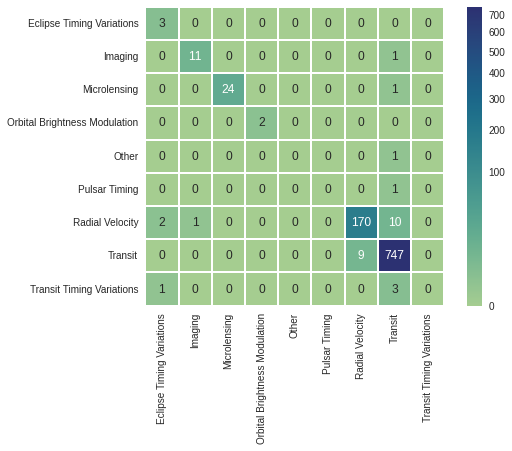

In [95]:
sn.heatmap(cm, annot=True, cmap='crest', norm=colors.PowerNorm(0.4), square=True, fmt='g', xticklabels=labels, yticklabels=labels, linewidths=1)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


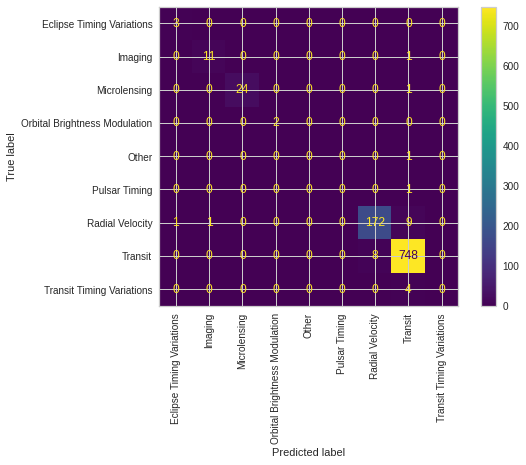

In [29]:
plot_confusion_matrix(ts_model, X_test.loc[:, X_train.columns!='rowid'], y_test, display_labels=labels, xticks_rotation='vertical')

In [42]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: labels[0], 
                                        1: labels[1], 
                                        2: labels[2], 
                                        3: labels[3], 
                                        4: labels[4], 
                                        5: labels[5], 
                                        6: labels[6], 
                                        7: labels[7], 
                                        8: labels[8]})
                                        
    # Fitting to the training data first then scoring with the test data  
    plt.figure(figsize=(16, 12))                                  
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


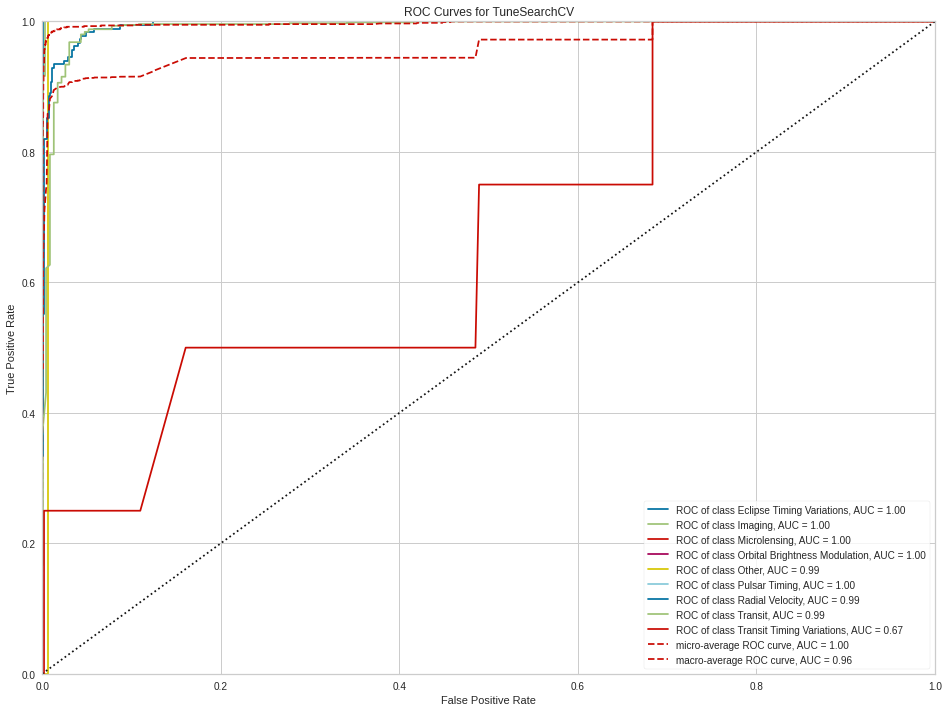

In [43]:
visualizer = plot_ROC_curve(ts_model, X_train, y_train, X_test, y_test)

## Feature Importance

In [96]:
estimator = ts_model.best_estimator_[-1]

In [97]:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_train.loc[:, X_train.columns!='rowid'])

In [98]:
Xtr = pd.DataFrame(X_train.loc[:, X_train.columns!='rowid'], columns=X_train.loc[:, X_train.columns!='rowid'].columns)

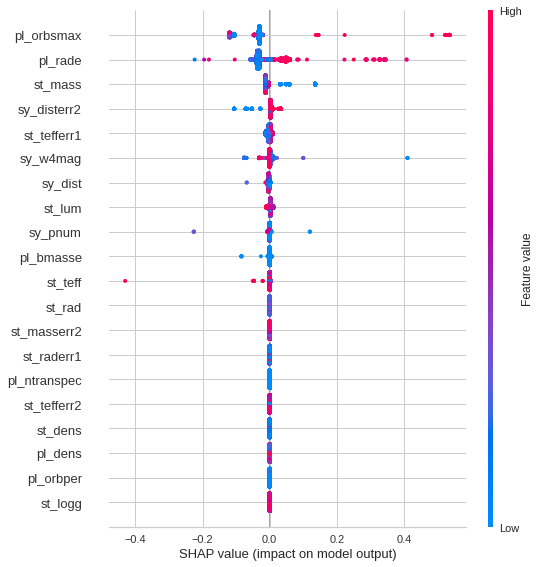

In [99]:
shap.summary_plot(shap_values[1], Xtr)

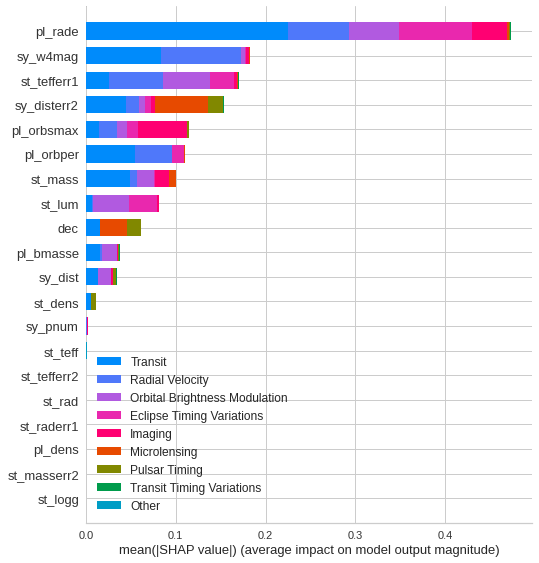

In [100]:
shap.summary_plot(shap_values, X_train.loc[:, X_train.columns!='rowid'].values, plot_type="bar", class_names=labels, feature_names = X_train.loc[:, X_train.columns!='rowid'].columns)

## KS-tests

In [113]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['col_name'][:12]

4         pl_rade
30       sy_w4mag
8     st_tefferr1
27    sy_disterr2
3      pl_orbsmax
2       pl_orbper
12        st_mass
14         st_lum
18            dec
5       pl_bmasse
26        sy_dist
16        st_dens
Name: col_name, dtype: object

In [114]:
important_features = feature_importance['col_name'][:12] # ['pl_rade', 'st_mass', 'pl_orbper', 'pl_orbsmax', 'sy_bmag', 'sy_disterr2', 'st_lum', 'elon', 'dec', 'st_raderr1', 'st_teff', 'st_rad']
imputer = SimpleImputer(strategy='median')
measurement_df = imputer.fit_transform(df[important_features])
measurement_df = pd.DataFrame(measurement_df, columns=important_features)
measurement_df['discoverymethod'] = df['discoverymethod']

In [115]:
other_list = ['Pulsation Timing Variations', 'Astrometry', 'Disk Kinematics'] 
measurement_df['discoverymethod'] = measurement_df['discoverymethod'].replace(to_replace=other_list, value='Other')

In [116]:
unique_methods = np.unique(measurement_df['discoverymethod'].values.copy())
results = []
for method in np.unique(measurement_df['discoverymethod']):
  tmp_methods = unique_methods[unique_methods != method]
  for method2 in tmp_methods:
    for feature in important_features:
      statistic, p_value = ks_2samp(measurement_df[measurement_df['discoverymethod'] == method][feature], 
                                    measurement_df[measurement_df['discoverymethod'] == method2][feature])
      results.append([method, method2, feature, p_value, statistic])


results_df = pd.DataFrame(results, columns=['Source Method', 'Target Method', 'Feature', 'P-value', 'Statistic'])
      # print(f'{method}-{method2}--->{feature}--->p_value: {p_value}')

In [117]:
results_df.to_pickle('./ks_analysis_2.pkl')
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Source Method  864 non-null    object 
 1   Target Method  864 non-null    object 
 2   Feature        864 non-null    object 
 3   P-value        864 non-null    float64
 4   Statistic      864 non-null    float64
dtypes: float64(2), object(3)
memory usage: 33.9+ KB


In [118]:
def analyse_hypotheses(labels, source):
  for label in labels:
    count = 0
    if label != source:
      print(f'{source} <-> {label}')
      for value, feature in zip(results_df[results_df['Source Method'] == 'Transit'][results_df['Target Method'] == label]['P-value'],
                                results_df[results_df['Source Method'] == 'Transit'][results_df['Target Method'] == label]['Feature']):
        if value > 0.05:
          print(f'\tFailed to reject hypothesis for {feature} ----- P-Value={value:.3f}')
          count += 0
      
      if count == 0:
        print('\tRejected all hypotheses!')

In [119]:
for label in labels:
  analyse_hypotheses(labels, label)
  print('^^^^^^^^^^^^^^^^^^^^^^^^')
  print('========================')
  print('vvvvvvvvvvvvvvvvvvvvvvvv')

Eclipse Timing Variations <-> Imaging
	Rejected all hypotheses!
Eclipse Timing Variations <-> Microlensing
	Rejected all hypotheses!
Eclipse Timing Variations <-> Orbital Brightness Modulation
	Failed to reject hypothesis for pl_rade ----- P-Value=0.104
	Failed to reject hypothesis for sy_w4mag ----- P-Value=0.444
	Failed to reject hypothesis for pl_orbsmax ----- P-Value=0.114
	Failed to reject hypothesis for dec ----- P-Value=0.181
	Failed to reject hypothesis for pl_bmasse ----- P-Value=0.102
	Rejected all hypotheses!
Eclipse Timing Variations <-> Other
	Failed to reject hypothesis for sy_w4mag ----- P-Value=0.907
	Failed to reject hypothesis for st_tefferr1 ----- P-Value=0.329
	Failed to reject hypothesis for sy_disterr2 ----- P-Value=0.559
	Failed to reject hypothesis for st_mass ----- P-Value=0.207
	Failed to reject hypothesis for dec ----- P-Value=0.192
	Failed to reject hypothesis for sy_dist ----- P-Value=0.524
	Failed to reject hypothesis for st_dens ----- P-Value=0.403
	Rejec

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


	Rejected all hypotheses!
Radial Velocity <-> Imaging
	Rejected all hypotheses!
Radial Velocity <-> Microlensing
	Rejected all hypotheses!
Radial Velocity <-> Orbital Brightness Modulation
	Failed to reject hypothesis for pl_rade ----- P-Value=0.104
	Failed to reject hypothesis for sy_w4mag ----- P-Value=0.444
	Failed to reject hypothesis for pl_orbsmax ----- P-Value=0.114
	Failed to reject hypothesis for dec ----- P-Value=0.181
	Failed to reject hypothesis for pl_bmasse ----- P-Value=0.102
	Rejected all hypotheses!
Radial Velocity <-> Other
	Failed to reject hypothesis for sy_w4mag ----- P-Value=0.907
	Failed to reject hypothesis for st_tefferr1 ----- P-Value=0.329
	Failed to reject hypothesis for sy_disterr2 ----- P-Value=0.559
	Failed to reject hypothesis for st_mass ----- P-Value=0.207
	Failed to reject hypothesis for dec ----- P-Value=0.192
	Failed to reject hypothesis for sy_dist ----- P-Value=0.524
	Failed to reject hypothesis for st_dens ----- P-Value=0.403
	Rejected all hypoth